In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import simulator as faas


seed = 1

In [6]:
print(np.load('train_params.npy'))

ValueError: Cannot load file containing pickled data when allow_pickle=False

## Set up priors


In [2]:
import delfi.distribution as dd

upper = np.array([12,  10, 12,  10, -3, -4, -4,-4] + [0.1,0])
lower = np.array([4,  2, 4, 2, -10, -10, -10, -12] + [-0.1,-0.5])

prior_mean = np.array([0]*8 + [1.1e-03, -3.9e-01])
prior_cov = np.diag(np.array([10]*8+[(0.0011*0.2)**2, (0.39*0.2)**2]))

prior = dd.Uniform(lower= lower, upper=upper, seed=seed)

epsilon_mean = np.array([0]*94)
epsilon_cov = np.diag(np.array([0.5] * 94))
epsilon_prior = dd.Gaussian(m=epsilon_mean, S=epsilon_cov, seed=seed)

## Set up Simulator

In [3]:
faasSimulator = faas.faas_Model()

## repeating last fratio for short rows
def simulator(th, seed, simulator_args, batch):
    
    eps_prior = simulator_args[0]
    eps = eps_prior.gen()[0]
    #eps.index = ['epsilon' + str(i) for i in np.arange(0,94)]
    #eps = [0] * 94
    
    if len(th) < 104:
        return faasSimulator.forward(np.concatenate([th, eps]), seed)
    else:
        return faasSimulator.forward(th, seed)

simulator_args = [epsilon_prior]
theta0 = faasSimulator.theta0

theta_f = [8.886491e+00,  7.924279e+00,
   1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
  -6.585027e+00,  1.100000e-03, -3.900000e-01]




In [4]:
from delfi.simulator.BaseSimulator import BaseSimulator

class Faas(BaseSimulator):
    def __init__(self, batch=0, simulator_args = simulator_args, seed=None):
        """Faas simulator

        Parameters
        ----------
        seed : int or None
            If set, randomness across runs is disabled
        """
        dim_param = 104

        super().__init__(dim_param=dim_param, seed=seed)
        self.batch = batch
        self.simulator_args = simulator_args
        self.seed = seed
        self.FaasSimulator = simulator
        self.time = np.genfromtxt('data/time_points.csv', delimiter=',')

    def gen_single(self, params):
        """Forward model for simulator for single parameter set

        Parametersnp.nanstd(stats, axis=0)
        ----------
        params : list or np.array, 1d of length dim_param
            Parameter vector

        Returns
        -------
        dict : dictionary with data
            The dictionary must contain a key data that contains the results of
            the forward run. Additional entries can be present.
        """
        params = np.asarray(params)

        assert params.ndim == 1, 'params.ndim must be 1'

        hh_seed = self.seed

        states = self.FaasSimulator(th = params, seed = seed, simulator_args = self.simulator_args, batch = self.batch)
        if np.isnan(states.flatten()).any() or np.isinf(states.flatten()).any():
            states = np.random.randn(94,259)
                #return d.flatten()
        
        return {'data': states, 'time': self.time}

## Summary Statistics

In [ ]:
from delfi.summarystats.Score_Sum_Stats import Score_MLE_Projected
sim = Faas(simulator_args=simulator_args)
ndata = len(sim.gen_single(theta_f)['data'].flatten())
nuisance_indices = np.arange(10,104)
Score = Score_MLE_Projected(ndata = ndata, theta_fiducial=theta_f + [0.1]*94, nuisances=nuisance_indices, seed=0, n_summary=10)
Score.compute_mean_covariance(sim.gen_single, 50, simulator_args=simulator_args)
Score.compute_derivatives(sim.gen_single, 50, [0.01]*10 + [0.5]*94, simulator_args=simulator_args)
print(Score.mu.shape)
print(Score.Cinv.shape)
print(Score.dmudt.shape)
Score.compute_fisher()

In [ ]:
np.save('mu.npy', Score.mu)
np.save('Cinv.npy', Score.Cinv)
np.save('F.npy', Score.F)
np.save('dmudt.npy', Score.dmudt)
#np.save('dCdt.npy' , Score.dCdt)

In [5]:
from delfi.summarystats.Score_Sum_Stats import Score_MLE_Projected

mu = np.load('mu.npy')
Cinv = np.load('Cinv.npy', allow_pickle=True)
#Cinv = np.diag([10]*8178)
F = np.load('F.npy', allow_pickle=True)
dmudt = np.load('dmudt.npy', allow_pickle=True)
dCdt = np.load('dCdt.npy', allow_pickle=True)

sim = Faas(simulator_args=simulator_args)
ndata = len(sim.gen_single(theta_f)['data'].flatten())
nuisance_indices = np.arange(10,104)
print(nuisance_indices)
#print((theta_f + [0.1]*94)[np.delete(np.arange(len(theta_f + [0]*94)), nuisance_indices)])
Score = Score_MLE_Projected(ndata = ndata, theta_fiducial=np.asarray(theta_f + [0.1]*94), nuisances=nuisance_indices, seed=0, mu=mu, Cinv=Cinv, dmudt=dmudt,F=F, n_summary = 10)
#Score.compute_mean_covariance(sim.gen_single, 10, simulator_args=simulator_args)
#Score.compute_derivatives(sim.gen_single, 10, [0.01]*10 + [0.5]*94, simulator_args=simulator_args)
print(Score.mu.shape)
print(Score.Cinv.shape)
print(Score.dmudt.shape)
#print(Score.F.shape) 
#Score.compute_fisher()

[ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103]
(8178,)
(8178, 8178)
(104, 8178)


In [6]:
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats

from scipy import stats
from scipy.signal import find_peaks, peak_widths

class FaasStats(BaseSummaryStats):
    """Moment based SummaryStats class for the faas model

    Calculates summary statistics
    """
    def __init__(self, seed=None):
        """See SummaryStats.py for docstring"""
        super(FaasStats, self).__init__(seed=seed)
        self.time = np.genfromtxt('data/time_points.csv', delimiter=',')
    
    def compressor(self, d, t):
            comp_d = []

#             for i in d:
#                 #mean of final ten entries
#                 final = np.mean(i[-10:])
#                 #median of 3 highest points
#                 peak = np.max(i)
#                 #time to peak
#                 time_peak = t[np.argmax(i)]
#                 #sd = np.std(i[-10:])
#                 #time to final
#                 #time_final = np.argmax(np.logical_and((i[time_peak:] >= final - sd),(i[time_peak:] <= final + sd)) == True) + time_peak
#                 diff_peak_final = (final - peak)/peak * 100
#                 first = np.mean(i[:5])
#                 diff_peak_first = first - peak
#                 diff_first_final = first - final
#                 mid = i[len(i)//2]
#                 diff_first_mid = first - mid
#                 diff_final_mid = final - mid
#                 diff_peak_mid = peak - mid
#                 if time_peak > 259:
#                     time_peak = np.random.uniform(0, 259)
#                 if diff_peak_final > 25:
#                     diff_peak_final = np.random.uniform(0.1, 0.2)
                
#                 min_slope = np.diff(i).min()
#                 max_slope = np.diff(i[10:]).max()
                
#                 max_slope_index = t[np.argmax(np.diff(i[10:])) + 10] 
#                 min_slope_index = t[np.argmin(np.diff(i[10:]))] 
                
#                 #mean slope for first 10, 20, and then the remaining trace
#                 mean_10 = np.mean(np.diff(i)[:10])
#                 mean_30 = np.mean(np.diff(i)[10:30])
#                 mean_rest = np.mean(np.diff(i)[30:])
                
#                 #moments
#                 #mom_1 = stats.moment(i, 1, nan_policy = 'omit')
#                 mom_2 = stats.moment(i, 2, nan_policy = 'omit')
#                 mom_3 = stats.moment(i, 3, nan_policy = 'omit')
#                 mom_4 = stats.moment(i, 4, nan_policy = 'omit')
#                 mom_5 = stats.moment(i, 5, nan_policy = 'omit')
                
#                 #moments of differenced trace
#                 mom_diff_1 = stats.moment(np.diff(i), 1, nan_policy = 'omit')
#                 mom_diff_2 = stats.moment(np.diff(i), 2, nan_policy = 'omit')
#                 mom_diff_3 = stats.moment(np.diff(i), 3, nan_policy = 'omit')
#                 mom_diff_4 = stats.moment(np.diff(i), 4, nan_policy = 'omit')
#                 mom_diff_5 = stats.moment(np.diff(i), 5, nan_policy = 'omit')
                
#                 # peaks
#                 #peaks, _ = find_peaks(i)
#                 #peaks_widths = peak_widths(i, peaks)[0]
                
#                 #comp_d.append([time_peak, min_slope, max_slope, diff_peak_final, diff_peak_first, max_slope_index, 
#                 #               min_slope_index, mean_10, mean_30, mean_rest, diff_first_mid, diff_final_mid, 
#                 #               diff_peak_mid, mom_2, mom_3, mom_4, mom_5,
#                 #               mom_diff_1, mom_diff_2, mom_diff_3, mom_diff_4, mom_diff_5])
#                 #               #peaks, peaks_widths])


            #out = np.asarray(comp_d).flatten()
            #out = comp_d
            out = d.flatten()
            if np.isnan(out).any() or np.isinf(out).any():
                return np.random.randn(out.shape[0])**2
                #return d.flatten()

            #return out + np.random.rand(6*len(d))
            return out
    
    def calc(self, repetition_list):
        """Calculate summary statistics

        Parameters
        ----------
        repetition_list : list of dictionaries, one per repetition
            data list, returned by `gen` method of Simulator instance

        Returns
        -------
        np.array, 2d with n_reps x n_summary
        """
        stats = []
        for r in range(len(repetition_list)):
            x = repetition_list[r]

            N = x['data']
            t = self.time

            # concatenation of summary statistics
            sum_stats_vec = self.compressor(N, t)
            #sum_stats_vec = sum_stats_vec[0:self.n_summary]

            stats.append(sum_stats_vec)

        return np.asarray(stats)
    


## Generator

In [7]:
import delfi.generator as dg


m = Faas(seed=0)
s = FaasStats(seed=0)
g = dg.Default(model=m, prior=prior, summary=s)

## Test with simulated data

In [8]:
labels_params = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0'] + ['eps' + str(i) for i in range(93)]


data = np.genfromtxt('data/timecourse.csv', delimiter=',').T
print(data.shape)
mask = np.isnan(data)
data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])

print(data)

data = {'data': data[:,::3], 'time': np.genfromtxt('data/time_points.csv', delimiter=',')}

(94, 259)
[[ 1.53874     1.52949     1.52024    ...  1.22611     1.43572667
   1.64534333]
 [ 1.85496     1.85207     1.84919    ...  1.3128      1.56277
   1.81274   ]
 [ 2.06271     2.07622     2.08974    ...  1.47581     1.78714
   2.09847   ]
 ...
 [15.2519     15.5032     15.6159     ... 17.8333     17.3501
  17.479     ]
 [16.473      16.802      16.9616     ... 21.1703     20.9748
  21.382     ]
 [15.7665     16.0305     16.1803     ... 21.2085     20.9053
  20.6735    ]]


In [9]:
# true parameters and respective labels
true_params = np.array([8.886491e+00,  7.924279e+00, 1.050515e+01,  7.397940e+00, 
                        -3.682371e+00, -4.509306e+00, -6.162727e+00, -6.585027e+00,  
                        1.100000e-03, -3.900000e-01])       
labels_params = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0']



#true_params = np.array([8.886491e+00,  7.924279e+00,
#   1.050515e+01,  7.397940e+00, -3.682371e+00])       
#labels_params = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN']# 'logKDRN', 'logKDRC', 'malpha', 'alpha0']


# observed data: simulation given true parameters
obs = m.gen_single(true_params)
print(obs['data'].shape)
print(obs['data'].flatten().shape)

(94, 259)
(24346,)


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(7,5))
ax = plt.subplot()
for i in data['data']:
    plt.plot(data['time'],i)
plt.ylabel('voltage (mV)')
plt.title('observed data')
ax.set_xticks([])

for i in obs['data']:
    plt.plot(obs['time'],i)
plt.ylabel('voltage (mV)')
plt.title('observed data')
ax.set_xticks([])


In [10]:
obs_stats = s.calc([data])
print(obs_stats)
print(obs_stats.shape)
print()

[[ 1.53874  1.51901  1.55296 ... 20.6557  20.8518  20.6735 ]]
(1, 8178)



## Inference

In [11]:
seed_inf = 20

pilot_samples = 20

# training schedule
n_train = 500
n_rounds = 5

# fitting setup
minibatch = 100
epochs = 100
val_frac = 0.05

# network setup
n_hiddens = [50]*5

# convenience
prior_norm = True

# MAF parameters
density = 'maf'
n_mades = 5       # number of MADES

In [ ]:
import delfi.inference as infer
 
# inference object
res = infer.SNPEC(g,
                obs=obs_stats,
                n_hiddens=n_hiddens,
                seed=seed_inf,
                pilot_samples=pilot_samples,
                n_mades=n_mades,
                prior_norm=prior_norm,
                density=density, verbose=True)

# train
log, _, posterior = res.run(
                    n_train=n_train,
                    n_rounds=n_rounds,
                    minibatch=minibatch,
                    epochs=epochs,
                    silent_fail=False,
                    proposal='prior',
                    val_frac=val_frac,
                    verbose=True,)

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.plot(log[0]['loss'],lw=2)
plt.xlabel('iteration')
plt.ylabel('loss');

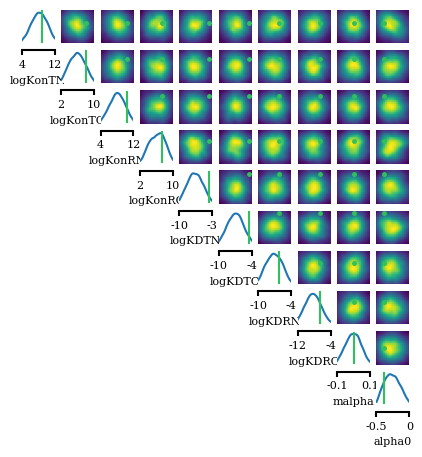

In [11]:
from delfi.utils.viz import samples_nd

#lower= [4,2,4,2], upper=[12,10,12,10]

prior_min = lower
prior_max = upper
prior_lims = np.concatenate((prior_min.reshape(-1,1),prior_max.reshape(-1,1)),axis=1)

#posterior_samples = posterior[0].gen(10000)
posterior_samples = np.load('posterior_samples_summaries.npy')
###################
# colors
hex2rgb = lambda h: tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

# RGB colors in [0, 255]
col = {}
col['GT']      = hex2rgb('30C05D')
col['SNPE']    = hex2rgb('2E7FE8')
col['SAMPLE1'] = hex2rgb('8D62BC')
col['SAMPLE2'] = hex2rgb('AF99EF')

# convert to RGB colors in [0, 1]
for k, v in col.items():
    col[k] = tuple([i/255 for i in v])

###################
# posterior
fig, axes = samples_nd(posterior_samples,
                       limits=prior_lims,
                       ticks=prior_lims,
                       labels=labels_params,
                       fig_size=(5,5),
                       diag='kde',
                       upper='kde',
                       hist_diag={'bins': 50},
                       hist_offdiag={'bins': 50},
                       kde_diag={'bins': 50, 'color': col['SNPE']},
                       kde_offdiag={'bins': 50},
                       points=[true_params],
                       points_offdiag={'markersize': 5},
                       points_colors=[col['GT']],
                       title='');

In [19]:
from sklearn.metrics import mean_squared_error
inferred_params = np.median(posterior_samples.reshape(10000,10), axis=0)
print(inferred_params)
print(true_params)

data = m.gen_single(inferred_params)
print(data['data'][6])
print(obs['data'][6])
#print(s.calc([data]))
#print(s.calc([obs]))
print(mean_squared_error(s.calc([data]),s.calc([obs])))

[ 8.27012336e+00  5.90060312e+00  8.07894700e+00  6.25146316e+00
 -6.63770677e+00 -6.95857517e+00 -7.09041878e+00 -8.25148661e+00
 -1.08392363e-03 -2.62783470e-01]
[ 8.886491e+00  7.924279e+00  1.050515e+01  7.397940e+00 -3.682371e+00
 -4.509306e+00 -6.162727e+00 -6.585027e+00  1.100000e-03 -3.900000e-01]
[0.99999937 0.99999935 0.99999934 0.99999932 0.99999931 0.99999929
 0.99999927 0.99999926 0.99999924 0.9999981  0.99999111 0.99998413
 0.99997714 0.99997015 0.99995618 0.99994221 0.99992823 0.99991426
 0.99990029 0.99988632 0.99987234 0.99985837 0.9998444  0.99983043
 0.99981645 0.99980248 0.99978851 0.99977453 0.99976056 0.99974659
 0.99973262 0.99971864 0.99970467 0.9996907  0.99967673 0.99966275
 0.99972639 0.99983172 0.9999128  0.99995475 0.99997471 0.99998571
 0.99999215 0.99999573 0.99999766 0.99999871 0.99999929 0.99999961
 0.99999979 0.99999988 0.99999994 0.99999997 1.00000002 1.00000007
 1.0000001  1.00000012 1.00000013 1.00000013 1.00000012 1.0000001
 1.00000007 1.00000007 1

[]

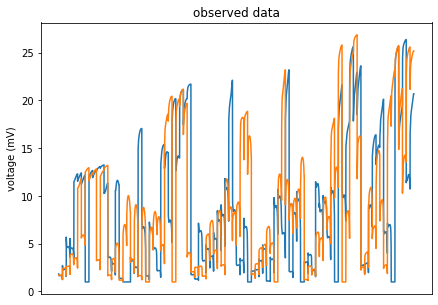

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

params = np.array([8e+00,  7.924279e+00, 1.050515e+01,  7.397940e+00, 
                        -3.682371e+00, -4.509306e+00, -6.162727e+00, -6.585027e+00,  
                        1.100000e-03, -3.900000e-01])

data = m.gen_single(params)
fig = plt.figure(figsize=(7,5))
ax = plt.subplot()

plt.plot(data['data'].flatten())
plt.ylabel('voltage (mV)')
plt.title('observed data')
ax.set_xticks([])

#for i in obs['data'][0:10]:
plt.plot(obs['data'].flatten())
plt.ylabel('voltage (mV)')
plt.title('observed data')
ax.set_xticks([])